In [1]:
import re
import sys
from typing import TextIO

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt, gridspec, colors




def get_dataframe(filename: str) -> pd.DataFrame:
    """
    Load a dataframe from the given pickle file
    :param filename: valid dataframe pickle - gz, bz2, zip, or xz compressed
    :return: the loaded dataframe
    """
    df = pd.read_pickle(filename)

    # Make a date column
    df["date"] = pd.to_datetime(df["p2a"], cache=True)

    # Convert af few object columns to categories
    _category_cols = ["k", "p", "q", "t", "l", "i", "h"]
    df[_category_cols] = df[_category_cols].astype("category")

    return df



In [41]:

def plot_fig(df: pd.DataFrame,
             fig_location: str = None,
             show_figure: bool = False):
    """

    Args:
        df (pd.DataFrame): _description_
        fig_location (str, optional): _description_. Defaults to None.
        show_figure (bool, optional): _description_. Defaults to False.
    """

    weather_labels = ["Ideal", "Fog", "Light rain", "Rain",
                  "Snow", "Frost", "Strong wind"]

    vehicle_types = ["moped", "motorcycle", "car", "car with trailer", "truck", "truck with trailer", "truck with semi-trailer", "bus", "tractor", "tram", 
    "trolleybus", "other motor vehicle", "bicycle", "horse", "other non-motor vehicle", "train", "unknown", "other vehicle"]

    # categorize and label the weather
    df["weather"] = pd.cut(df["p18"], [i for i in range(8)],
                           labels=weather_labels)

    # filter out "other" weather conditions
    df = df[df["p18"] > 0]

    # filter only accidents with casualties
    df = df[df["p13a"] > 0]

    # filter only rain and light rain
    df = df[df["p18"].isin([3, 4])]

    # create a new column for month
    df["month"] = df["date"].dt.month

    # aggregate by type of vehicle from column p44 and by month from column p2a
    groups = df.groupby(["p44", "month"]).agg({"p1": "count"}).reset_index()

    # map the vehicle types to the vehicle types list
    groups["p44"] = groups["p44"].map({i: vehicle_types[i] for i in range(len(vehicle_types))})

    # group car and car with trailer together as car, truck and truck with trailer and truck with semi-trailer together as truck
    groups["p44"] = groups["p44"].replace({"car with trailer": "car", "truck with trailer": "truck", "truck with semi-trailer": "truck"})

    # group all other vehicle types together as other
    groups["p44"] = groups["p44"].replace({"moped": "other", "motorcycle": "other", "bus": "other", "tractor": "other", "tram": "other", "trolleybus": "other", "other motor vehicle": "other", "bicycle": "other", "horse": "other", "other non-motor vehicle": "other", "train": "other", "unknown": "other", "other vehicle": "other"})


    # group by vehicle type and month
    groups = groups.groupby(["p44", "month"]).agg({"p1": "sum"}).reset_index()

    # print(groups)

    # plot the data
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(x="month", y="p1", hue="p44", data=groups, ax=ax)
    ax.set_title("Accidents by vehicle type and month")
    ax.set_xlabel("Month")
    ax.set_ylabel("Number of accidents")
    ax.legend(loc="upper right")

    # show line for each y value
    ax.grid(axis="y")
    # show line with average value
    ax.axhline(groups["p1"].mean(), color="black", linestyle="--")
    # label the average line
    ax.text(
        -1.3,
        groups["p1"].mean(),
        "Average",
        horizontalalignment="center",
        verticalalignment="center",
        color="black",
        fontsize=12,
        fontweight="bold",
    )

    plt.savefig("accidents_by_vehicle_type_and_month.png")
    if fig_location is not None:
        plt.savefig(fig_location)
    if show_figure:
        plt.show()
    
    


In [2]:

df_v = get_dataframe("accidents.pkl.gz")


In [3]:

df_v.shape


(572934, 66)

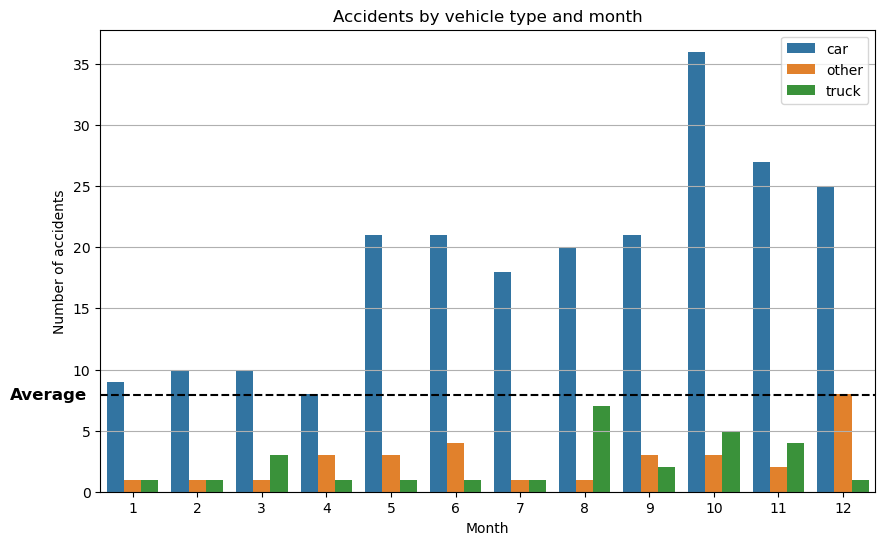

In [42]:
df = df_v.copy()
plot_fig(df, fig_location="fig.pdf", show_figure=False)


In [39]:

def create_table(df: pd.DataFrame) -> pd.DataFrame:
    """
    Format the table so that it represents something useful
    :param df: dataframe to examine
    :return: formatted dataframe
    """
    weather_labels = ["Ideal", "Fog", "Light rain", "Rain",
                  "Snow", "Frost", "Strong wind"]

    vehicle_types = ["moped", "motorcycle", "car", "car with trailer", "truck", "truck with trailer", "truck with semi-trailer", "bus", "tractor", "tram", 
    "trolleybus", "other motor vehicle", "bicycle", "horse", "other non-motor vehicle", "train", "unknown", "other vehicle"]

    df_save = df.copy()
    # categorize and label the weather
    df["weather"] = pd.cut(df["p18"], [i for i in range(8)],
                            labels=weather_labels)
    
    # filter out "other" weather conditions
    df = df[df["p18"] > 0]

    # filter only accidents with casualties
    df = df[df["p13a"] > 0]

    # filter only rain and light rain
    df = df[df["p18"].isin([3, 4])]

    # create a new column for month
    df["month"] = df["date"].dt.month

    # aggregate by type of vehicle from column p44 and by month from column p2a
    groups = df.groupby(["p44", "month"]).agg({"p1": "count"}).reset_index()

    # map the vehicle types to the vehicle types list
    groups["p44"] = groups["p44"].map({i: vehicle_types[i] for i in range(len(vehicle_types))})

    # group car and car with trailer together as car, truck and truck with trailer and truck with semi-trailer together as truck
    groups["p44"] = groups["p44"].replace({"car with trailer": "car", "truck with trailer": "truck", "truck with semi-trailer": "truck"})

    # group all other vehicle types together as other
    groups["p44"] = groups["p44"].replace({"moped": "other", "motorcycle": "other", "bus": "other", "tractor": "other", "tram": "other", "trolleybus": "other", "other motor vehicle": "other", "bicycle": "other", "horse": "other", "other non-motor vehicle": "other", "train": "other", "unknown": "other", "other vehicle": "other"})

    # group by vehicle type and month
    groups = groups.groupby(["p44", "month"]).agg({"p1": "sum"}).reset_index()

    # create pivot table
    groups = groups.pivot(index="month", columns="p44", values="p1")


    # create a new column for total accidents in each month
    groups["total"] = groups.sum(axis=1)

    # create a new column for percentage
    groups["percentage_car"] = (groups["car"] / groups["total"] * 100).round(2)
    groups["percentage_truck"] = (groups["truck"] / groups["total"] * 100).round(2)
    groups["percentage_other"] = (groups["other"] / groups["total"] * 100).round(2)

    # create a new column for monthly total percentage of over all accidents
    groups["total_percentage"] = (groups["total"] / groups["total"].sum() * 100).round(2)

    # add row for total
    groups.loc["total"] = groups.sum()

    # data type to int for all columns except percentage columns
    groups = groups.astype({"car": int, "truck": int, "other": int, "total": int})

    # data type to str for percentage columns and add % sign
    groups = groups.astype({"percentage_car": str, "percentage_truck": str, "percentage_other": str, "total_percentage": str})
    groups["percentage_car"] = groups["percentage_car"] + "%"
    groups["percentage_truck"] = groups["percentage_truck"] + "%"
    groups["percentage_other"] = groups["percentage_other"] + "%"
    groups["total_percentage"] = groups["total_percentage"] + "%"

    # remove from total row values from percentage columns
    groups.loc["total", {"percentage_car", "percentage_truck", "percentage_other", "total_percentage"}] = ""

    print(groups)

    # create latex table from the dataframe and save it to a file called table.tex
    with open("table.tex", "w") as f:
        f.write(groups.style.to_latex())

    # print count of all accidents in the dataframe
    print(f"Total accidents: {df_save['p1'].count()}")
    print(f"Total accidents with casualties: {df_save[df_save['p13a'] > 0]['p1'].count()}")
    print(f"Percentage of accidents with casualties: {(df_save[df_save['p13a'] > 0]['p1'].count() / df_save['p1'].count() * 100).round(2)}%")
    print(f"Total accidents with casualties in rain: {df_save[(df_save['p13a'] > 0) & (df_save['p18'].isin([3, 4]))]['p1'].count()}")
    print(f"Percentage of accidents with casualties in rain: {(df_save[(df_save['p13a'] > 0) & (df_save['p18'].isin([3, 4]))]['p1'].count() / df_save[df_save['p13a'] > 0]['p1'].count() * 100).round(2)}%")
    

    # create picture of the table and save it to a file called table.png
    fig = plt.figure(figsize=(10, 6))
    gs = gridspec.GridSpec(1, 1)
    ax = fig.add_subplot(gs[0, 0])
    ax.axis("off")
    ax.axis("tight")
    ax.table(cellText=groups.values, colLabels=groups.columns, loc="center", rowLabels=groups.index)
    fig.tight_layout()
    plt.savefig("table.png")
    




/tmp/ipykernel_143693/3100694772.py:74: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  groups.loc["total", {"percentage_car", "percentage_truck", "percentage_other", "total_percentage"}] = ""


p44    car  other  truck  total percentage_car percentage_truck  \
month                                                             
1        9      1      1     11         81.82%            9.09%   
2       10      1      1     12         83.33%            8.33%   
3       10      1      3     14         71.43%           21.43%   
4        8      3      1     12         66.67%            8.33%   
5       21      3      1     25          84.0%             4.0%   
6       21      4      1     26         80.77%            3.85%   
7       18      1      1     20          90.0%             5.0%   
8       20      1      7     28         71.43%            25.0%   
9       21      3      2     26         80.77%            7.69%   
10      36      3      5     44         81.82%           11.36%   
11      27      2      4     33         81.82%           12.12%   
12      25      8      1     34         73.53%            2.94%   
total  226     31     28    285                               

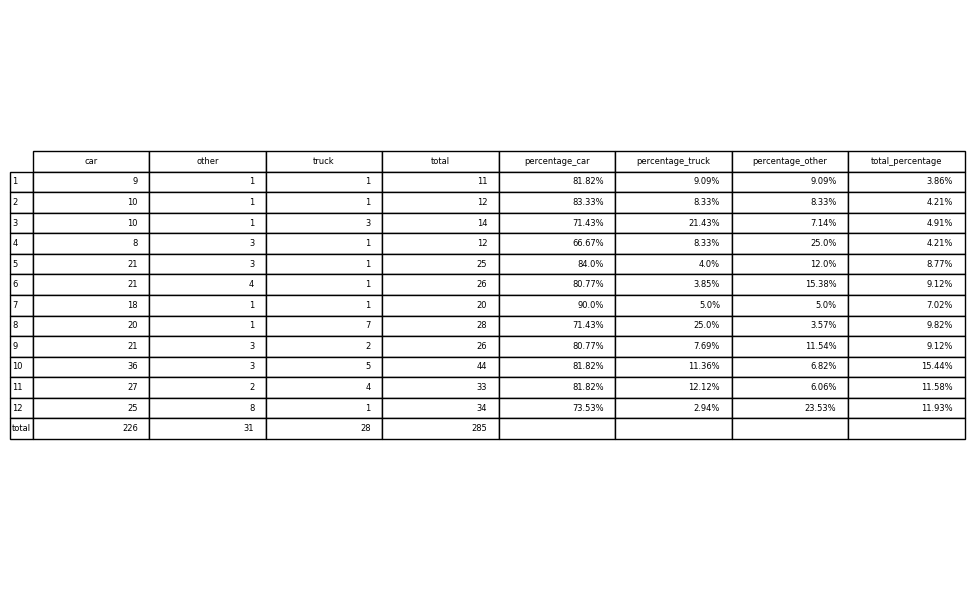

In [40]:
df = df_v.copy()
create_table(df)